# Notebook 01 — Data Preprocessing & Exploratory Data Analysis
## JFK Airport Daily Passenger Throughput Forecasting

This notebook performs:
1. Load raw TSA throughput data and aggregate hourly → daily
2. Load and clean NOAA weather data
3. Load BTS scheduled flights data
4. Merge all three datasets on date
5. Exploratory data analysis with visualizations
6. Save final processed dataset for modeling

---

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings, os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 40)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})

FIGURES = '../reports/figures'
os.makedirs(FIGURES, exist_ok=True)

print('Setup complete.')

Setup complete.


## 2. Load TSA Throughput Data

**Source:** TSA FOIA Electronic Reading Room, parsed via [mikelor/TsaThroughput](https://github.com/mikelor/TsaThroughput).

Each row = one hour at one checkpoint. We need to:
1. Fill NaN (closed checkpoint = 0 passengers)
2. Sum across all terminals per hour
3. Aggregate to daily totals

In [2]:
tsa = pd.read_csv('../data/raw/TsaThroughput_JFK.csv')
print(f'Shape: {tsa.shape}')
print(f'Date range: {tsa["Date"].min()} to {tsa["Date"].max()}')
tsa.head()

Shape: (56080, 10)
Date range: 2018-12-30 to 2025-05-31


,Date,Hour,JFK Terminal 1,JFK Terminal 2,JFK Terminal 4 Delta 1,JFK Terminal 4 FIS CP,JFK Terminal 4 Main,JFK Terminal 5,JFK Terminal 7,JFK Terminal 8
0,2018-12-30,00:00:00,212.00,6.00,NaN,NaN,361.00,48.00,9.00,NaN
1,2018-12-30,01:00:00,25.00,5.00,NaN,NaN,168.00,94.00,1.00,NaN
2,2018-12-30,02:00:00,1.00,2.00,NaN,NaN,216.00,213.00,2.00,NaN
3,2018-12-30,03:00:00,2.00,8.00,NaN,NaN,204.00,858.00,18.00,226.00
4,2018-12-30,04:00:00,150.00,107.00,NaN,NaN,933.00,"1,189.00",228.00,557.00


In [ ]:
# Identify terminal columns 
terminal_cols = [c for c in tsa.columns if c not in ['Date', 'Hour']]
print(f'Terminal columns ({len(terminal_cols)}):')
for col in terminal_cols:
    n_miss = tsa[col].isna().sum()
    pct = n_miss / len(tsa) * 100
    print(f'  {col}: {n_miss:,} missing ({pct:.1f}%)')

Terminal columns (8):
  JFK Terminal 1: 1,009 missing (1.8%)
  JFK Terminal 2: 31,321 missing (55.9%)
  JFK Terminal 4 Delta 1: 51,847 missing (92.5%)
  JFK Terminal 4 FIS CP: 42,174 missing (75.2%)
  JFK Terminal 4 Main: 1,010 missing (1.8%)
  JFK Terminal 5: 627 missing (1.1%)
  JFK Terminal 7: 2,218 missing (4.0%)
  JFK Terminal 8: 673 missing (1.2%)


**Key observations on terminal-level missing data:**
- **Terminal 2** — 55.9% missing → closed in 2023 for demolition
- **Terminal 4 Delta 1** — 92.5% missing → checkpoint added later
- **Terminal 4 FIS CP** — 75.2% missing → only for inbound re-screening (rare use)

NaN means the checkpoint was not operating; we treat it as 0 passengers.

In [4]:
# Fill NaN with 0, compute daily totals
tsa[terminal_cols] = tsa[terminal_cols].fillna(0)
tsa['hourly_total'] = tsa[terminal_cols].sum(axis=1)
tsa['Date'] = pd.to_datetime(tsa['Date'])

# Aggregate to daily
daily = tsa.groupby('Date').agg(
    daily_throughput=('hourly_total', 'sum'),
    **{col: (col, 'sum') for col in terminal_cols}
).reset_index()

print(f'Daily dataset: {daily.shape[0]} days')
print(f'Date range: {daily["Date"].min().date()} to {daily["Date"].max().date()}')
daily['daily_throughput'].describe()

Daily dataset: 2337 days
Date range: 2018-12-30 to 2025-05-31


count     2,337.00
mean     69,803.02
std      29,067.86
min       1,640.00
25%      56,115.00
50%      79,875.00
75%      90,942.00
max     114,397.00
Name: daily_throughput, dtype: float64

In [5]:
# Check for missing dates in the series
full_range = pd.date_range(daily['Date'].min(), daily['Date'].max(), freq='D')
missing_dates = full_range.difference(daily['Date'])
print(f'Missing dates: {len(missing_dates)}')
for d in missing_dates:
    print(f'  {d.date()} ({d.strftime("%A")})')

Missing dates: 8
  2022-07-02 (Saturday)
  2024-11-17 (Sunday)
  2024-11-18 (Monday)
  2024-11-19 (Tuesday)
  2024-11-20 (Wednesday)
  2024-11-21 (Thursday)
  2024-11-22 (Friday)
  2024-11-23 (Saturday)


**Missing dates:** 8 days total — 1 day in July 2022 and 7 consecutive days in Nov 2024. We will interpolate or leave as-is depending on modeling needs.

## 3. Load & Clean Weather Data

**Source:** NOAA Climate Data Online — Daily Summaries  
**Station:** USW00094789 (JFK International Airport)

In [6]:
weather_raw = pd.read_csv('../data/raw/weather.csv')
print(f'Raw shape: {weather_raw.shape}')
print(f'Columns: {list(weather_raw.columns)}')

Raw shape: (3319, 46)
Columns: ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND', 'AWND_ATTRIBUTES', 'PGTM', 'PGTM_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES', 'SNWD', 'SNWD_ATTRIBUTES', 'TAVG', 'TAVG_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES', 'WDF2', 'WDF2_ATTRIBUTES', 'WDF5', 'WDF5_ATTRIBUTES', 'WSF2', 'WSF2_ATTRIBUTES', 'WSF5', 'WSF5_ATTRIBUTES', 'WT01', 'WT01_ATTRIBUTES', 'WT02', 'WT02_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'WT04', 'WT04_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES', 'WT08', 'WT08_ATTRIBUTES', 'WT09', 'WT09_ATTRIBUTES']


In [7]:
# Drop constant columns, metadata, and quality-flag columns
drop_cols = ['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION',
             'PGTM', 'WDF2', 'WDF5']
attr_cols = [c for c in weather_raw.columns if '_ATTRIBUTES' in c]
drop_cols.extend(attr_cols)
drop_cols = [c for c in drop_cols if c in weather_raw.columns]

weather = weather_raw.drop(columns=drop_cols).copy()
weather = weather.rename(columns={'DATE': 'Date'})
weather['Date'] = pd.to_datetime(weather['Date'])

print(f'After cleaning: {weather.shape}')
print(f'Columns kept: {list(weather.columns)}')
print(f'Date range: {weather["Date"].min().date()} to {weather["Date"].max().date()}')

After cleaning: (3319, 18)
Columns kept: ['Date', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08', 'WT09']
Date range: 2017-01-01 to 2026-02-01


In [8]:
# Handle special values
# PRCP and SNOW: "T" (trace) was already coerced to NaN by read_csv; fill with 0
for col in ['PRCP', 'SNOW', 'SNWD']:
    if col in weather.columns:
        weather[col] = pd.to_numeric(weather[col], errors='coerce').fillna(0)

# Weather type columns (WT*): has a value = event occurred (1), NaN = did not (0)
wt_cols = [c for c in weather.columns if c.startswith('WT')]
for col in wt_cols:
    weather[col] = weather[col].notna().astype(int)

# Ensure numeric types
for col in ['AWND', 'TAVG', 'TMAX', 'TMIN', 'WSF2', 'WSF5']:
    if col in weather.columns:
        weather[col] = pd.to_numeric(weather[col], errors='coerce')

# Missing values report
print('Missing values:')
for col in weather.columns:
    if col == 'Date': continue
    n = weather[col].isna().sum()
    if n > 0:
        print(f'  {col}: {n} ({n/len(weather)*100:.1f}%)')

weather.describe().round(2)

Missing values:
  AWND: 34 (1.0%)
  TAVG: 11 (0.3%)
  TMAX: 1 (0.0%)
  WSF2: 34 (1.0%)
  WSF5: 48 (1.4%)


,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
count,3319,"3,285.00","3,319.00","3,319.00","3,319.00","3,308.00","3,318.00","3,319.00","3,285.00","3,271.00","3,319.00","3,319.00","3,319.00","3,319.00","3,319.00","3,319.00","3,319.00","3,319.00"
mean,2021-07-18 00:00:00,11.44,0.12,0.06,0.16,55.49,62.86,48.35,22.17,28.26,0.36,0.07,0.08,0.01,0.00,0.01,0.05,0.00
min,2017-01-01 00:00:00,2.91,0.00,0.00,0.00,9.00,14.00,3.00,6.90,10.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2019-04-10 12:00:00,8.28,0.00,0.00,0.00,42.00,49.00,35.00,17.00,21.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2021-07-18 00:00:00,10.51,0.00,0.00,0.00,55.00,63.00,48.00,21.00,27.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2023-10-25 12:00:00,13.87,0.05,0.00,0.00,70.00,78.00,63.00,25.90,34.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2026-02-01 00:00:00,30.42,8.05,11.90,13.00,90.00,102.00,81.00,53.90,70.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
std,NaN,4.23,0.33,0.55,1.00,16.11,17.14,16.22,6.79,9.07,0.48,0.26,0.27,0.12,0.03,0.08,0.21,0.05


## 4. Load BTS Scheduled Flights Data

**Source:** Bureau of Transportation Statistics — On-Time Performance  
**Processing:** Raw per-flight records were filtered to JFK and aggregated to
daily scheduled departure/arrival counts by .

Only **scheduled** counts are used as features (known in advance from published
schedules). Actual cancellations would be data leakage.

In [9]:
flights = pd.read_csv('../data/processed/jfk_daily_scheduled_flights.csv')
flights['date'] = pd.to_datetime(flights['date'])
flights = flights.rename(columns={'date': 'Date'})

print(f'Shape: {flights.shape}')
print(f'Date range: {flights["Date"].min().date()} to {flights["Date"].max().date()}')
print(f'Columns: {list(flights.columns)}')
flights.head()

Shape: (2373, 6)
Date range: 2019-01-01 to 2025-06-30
Columns: ['Date', 'scheduled_departures', 'scheduled_arrivals', 'cancelled_flights', 'total_scheduled_flights', 'cancellation_rate']


,Date,scheduled_departures,scheduled_arrivals,cancelled_flights,total_scheduled_flights,cancellation_rate
0,2019-01-01,325,320,2.00,645,0.00
1,2019-01-02,361,363,1.00,724,0.00
2,2019-01-03,337,340,0.00,677,0.00
3,2019-01-04,334,333,0.00,667,0.00
4,2019-01-05,311,309,0.00,620,0.00


In [ ]:
# Keep only safe-to-use features (no leakage)
flight_features = ['Date', 'scheduled_departures', 'scheduled_arrivals',
                   'total_scheduled_flights']

flights_clean = flights[flight_features].copy()

print('Scheduled flights summary:')
flights_clean.describe().round(1)

Scheduled flights summary:


,Date,scheduled_departures,scheduled_arrivals,total_scheduled_flights
count,2373,"2,373.00","2,373.00","2,373.00"
mean,2022-04-01 00:00:00,299.70,299.70,599.40
min,2019-01-01 00:00:00,27.00,25.00,52.00
25%,2020-08-16 00:00:00,272.00,272.00,543.00
50%,2022-04-01 00:00:00,344.00,344.00,688.00
75%,2023-11-15 00:00:00,366.00,366.00,732.00
max,2025-06-30 00:00:00,399.00,400.00,799.00
std,NaN,95.90,95.90,191.80


## 5. Merge All Datasets

In [12]:
# Step 1: TSA + Weather
merged = daily.merge(weather, on='Date', how='inner')
print(f'After TSA + Weather: {merged.shape[0]} days')

# Step 2: + Flights
merged = merged.merge(flights_clean, on='Date', how='left')
n_flight_match = merged['scheduled_departures'].notna().sum()
n_flight_miss = merged['scheduled_departures'].isna().sum()
print(f'After + Flights: {merged.shape[0]} days  (matched: {n_flight_match}, missing: {n_flight_miss})')

# Report all remaining NaN
print(f'Remaining missing values:')
na_report = merged.isna().sum()
na_report = na_report[na_report > 0]
if len(na_report) > 0:
    for col, n in na_report.items():
        print(f'  {col}: {n}')
else:
    print('  None')

print(f'Final dataset: {merged.shape[0]} rows x {merged.shape[1]} columns')
print(f'Date range: {merged["Date"].min().date()} to {merged["Date"].max().date()}')

# Save
merged.to_csv('../data/processed/jfk_daily_merged.csv', index=False)
print('Saved to data/processed/jfk_daily_merged.csv')
merged.head()

After TSA + Weather: 2337 days
After + Flights: 2337 days  (matched: 2335, missing: 2)
Remaining missing values:
  AWND: 29
  WSF2: 29
  WSF5: 37
  scheduled_departures: 2
  scheduled_arrivals: 2
  total_scheduled_flights: 2
Final dataset: 2337 rows x 30 columns
Date range: 2018-12-30 to 2025-05-31
Saved to data/processed/jfk_daily_merged.csv


,Date,daily_throughput,JFK Terminal 1,JFK Terminal 2,JFK Terminal 4 Delta 1,JFK Terminal 4 FIS CP,JFK Terminal 4 Main,JFK Terminal 5,JFK Terminal 7,JFK Terminal 8,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,scheduled_departures,scheduled_arrivals,total_scheduled_flights
0,2018-12-30,"98,287.00","12,170.00","7,945.00",0.00,918.00,"31,154.00","24,076.00","7,978.00","14,046.00",5.37,0.00,0.00,0.00,37.00,39.00,32,19.90,23.00,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2018-12-31,"79,117.00","10,481.00","5,035.00",0.00,633.00,"23,919.00","21,330.00","6,202.00","11,517.00",9.17,1.23,0.00,0.00,37.00,49.00,30,21.90,28.00,1,1,0,0,0,0,0,0,NaN,NaN,NaN
2,2019-01-01,"89,947.00","12,193.00","6,051.00",0.00,993.00,"26,152.00","22,099.00","8,002.00","14,457.00",18.34,0.11,0.00,0.00,51.00,59.00,40,33.10,40.90,1,1,0,0,0,0,0,0,325.00,320.00,645.00
3,2019-01-02,"96,649.00","12,711.00","6,842.00",0.00,840.00,"29,838.00","23,650.00","8,634.00","14,134.00",8.28,0.00,0.00,0.00,38.00,41.00,34,16.10,19.90,0,0,0,0,0,0,0,0,361.00,363.00,724.00
4,2019-01-03,"94,484.00","13,190.00","6,053.00",0.00,"1,228.00","29,001.00","22,248.00","8,675.00","14,089.00",11.41,0.00,0.00,0.00,41.00,46.00,34,25.90,32.00,0,0,0,0,0,0,0,0,337.00,340.00,677.00


## 6. Exploratory Data Analysis

### 6.1 Time Series Overview

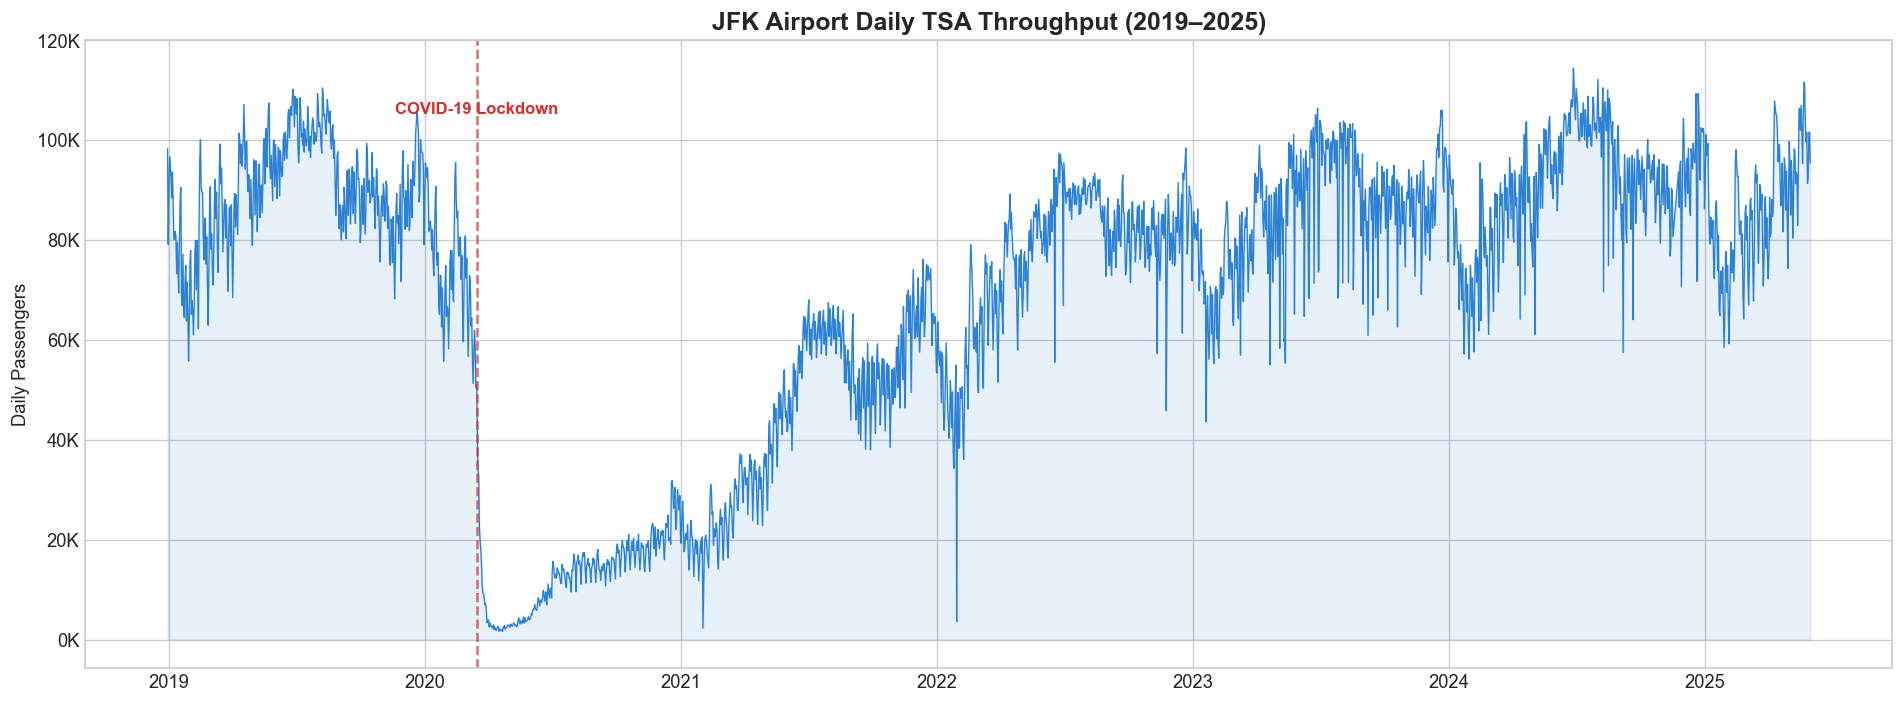

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(merged['Date'], merged['daily_throughput'], lw=0.8, color='#1976D2', alpha=0.9)
ax.fill_between(merged['Date'], merged['daily_throughput'], alpha=0.1, color='#1976D2')

# Mark COVID lockdown
covid_date = pd.Timestamp('2020-03-15')
ax.axvline(covid_date, color='#D32F2F', ls='--', alpha=0.7, lw=1.5)
ax.annotate('COVID-19 Lockdown', xy=(covid_date, merged['daily_throughput'].max()*0.92),
           fontsize=10, color='#D32F2F', fontweight='bold', ha='center')

ax.set_title('JFK Airport Daily TSA Throughput (2019–2025)', fontsize=15, fontweight='bold')
ax.set_ylabel('Daily Passengers')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
plt.tight_layout()
plt.savefig(f'{FIGURES}/01_time_series_overview.png')
plt.show()

### 6.2 Day-of-Week Patterns

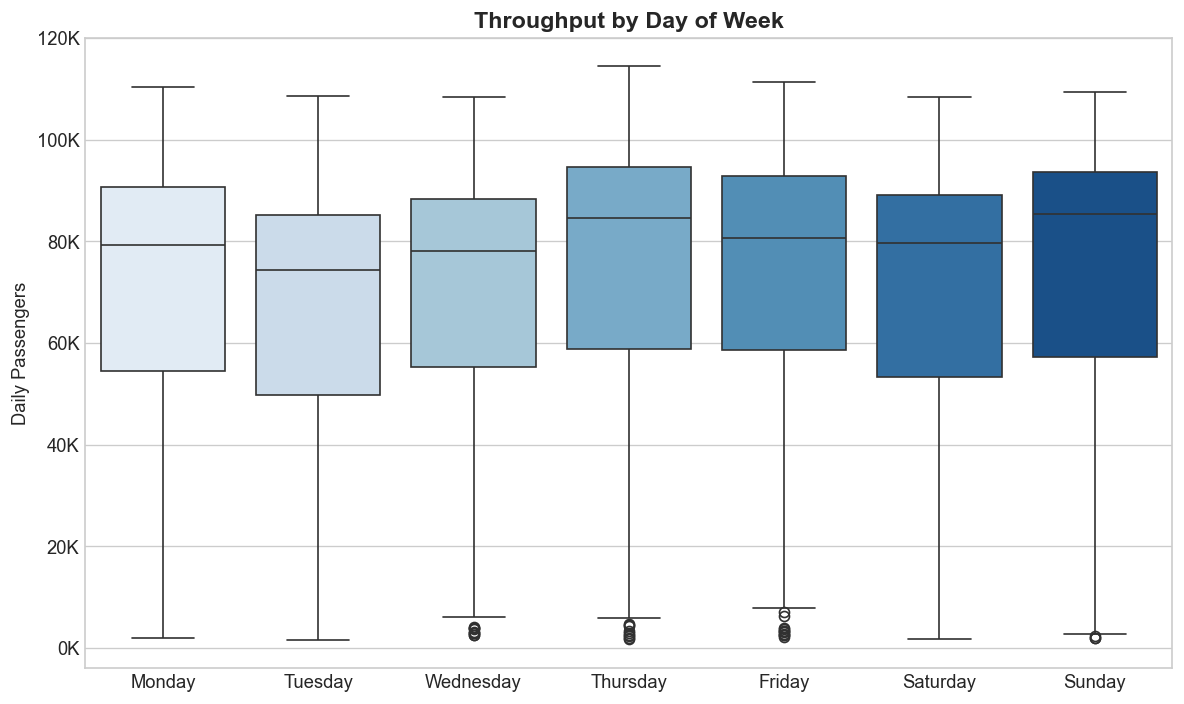

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
merged['dow_name'] = merged['Date'].dt.day_name()
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.boxplot(data=merged, x='dow_name', y='daily_throughput', order=order, palette='Blues', ax=ax)
ax.set_title('Throughput by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel(''); ax.set_ylabel('Daily Passengers')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
plt.tight_layout()
plt.savefig(f'{FIGURES}/02_day_of_week_boxplot.png')
plt.show()

### 6.3 Monthly Seasonality (excluding 2020–2021 COVID distortion)

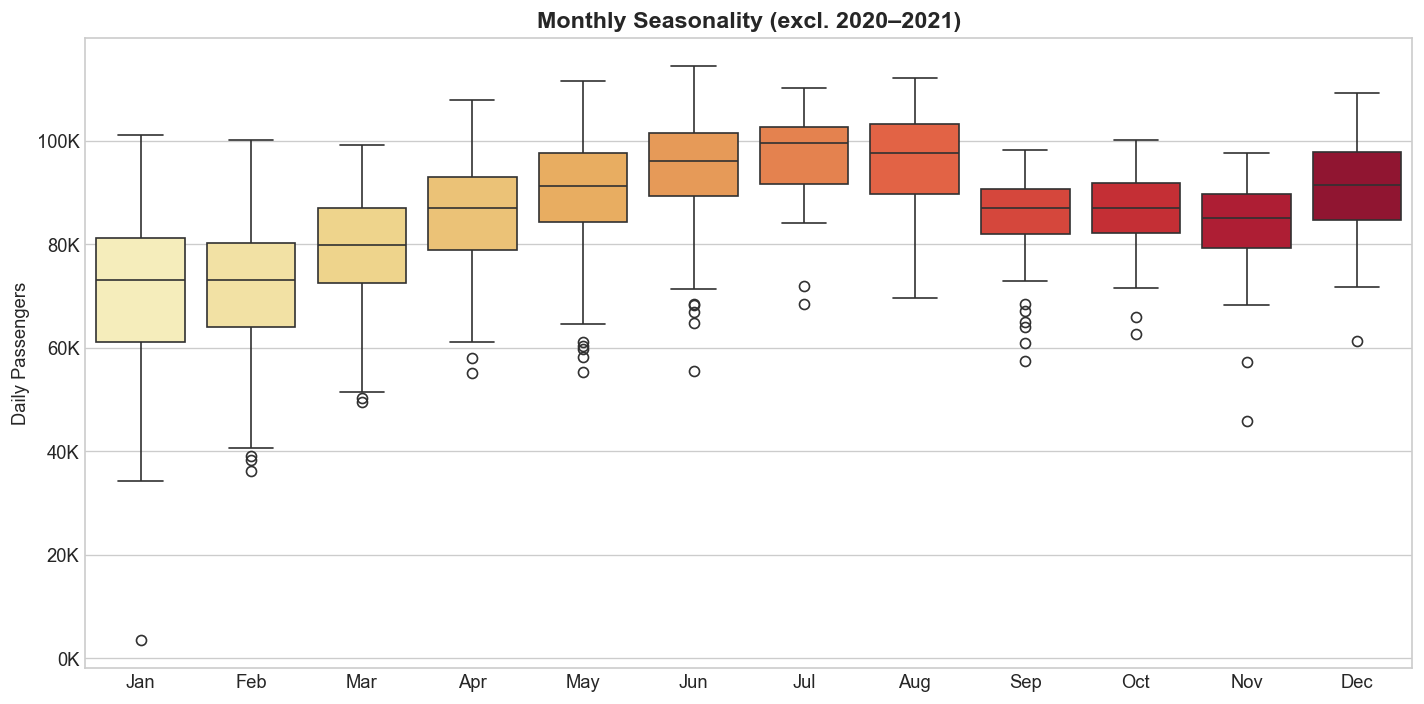

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
non_covid = merged[~merged['Date'].dt.year.isin([2020, 2021])].copy()
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
non_covid['month_name'] = non_covid['Date'].dt.month.map(dict(zip(range(1,13), month_names)))
sns.boxplot(data=non_covid, x='month_name', y='daily_throughput',
            order=month_names, palette='YlOrRd', ax=ax)
ax.set_title('Monthly Seasonality (excl. 2020–2021)', fontsize=14, fontweight='bold')
ax.set_xlabel(''); ax.set_ylabel('Daily Passengers')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
plt.tight_layout()
plt.savefig(f'{FIGURES}/03_monthly_seasonality.png')
plt.show()

### 6.4 Terminal Composition Over Time

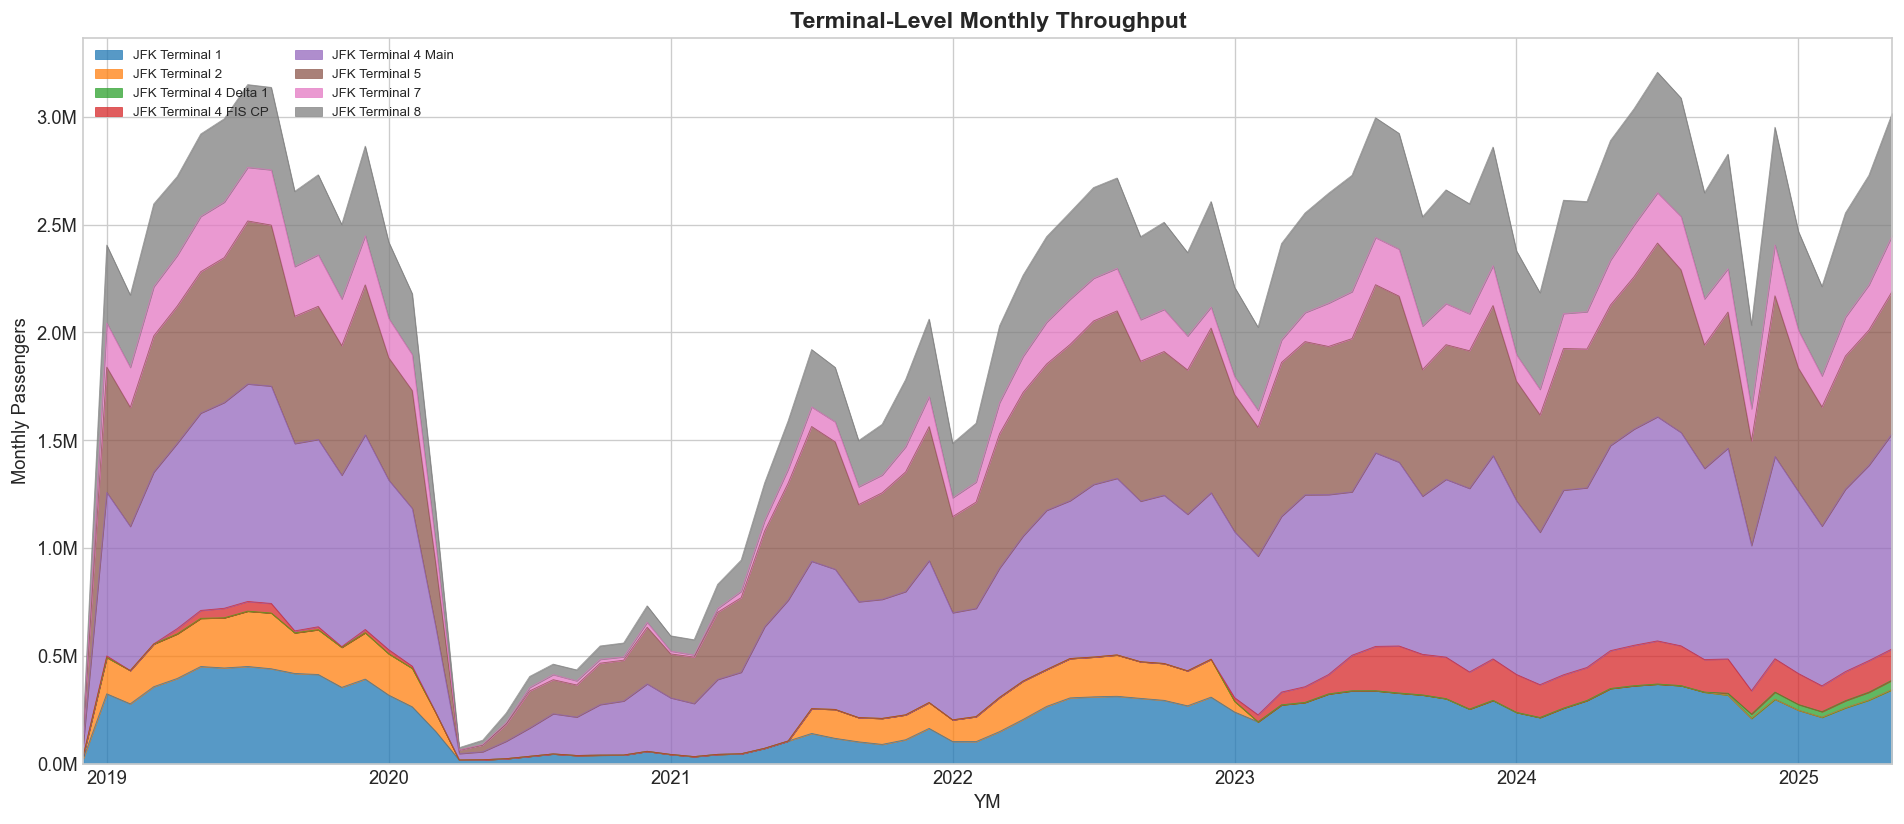

In [16]:
term_cols = [c for c in daily.columns if 'Terminal' in c]
monthly = daily.copy()
monthly['YM'] = monthly['Date'].dt.to_period('M').dt.to_timestamp()
monthly_agg = monthly.groupby('YM')[term_cols].sum()

fig, ax = plt.subplots(figsize=(16, 7))
monthly_agg.plot.area(ax=ax, alpha=0.75, linewidth=0.5)
ax.set_title('Terminal-Level Monthly Throughput', fontsize=14, fontweight='bold')
ax.set_ylabel('Monthly Passengers')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.legend(fontsize=8, loc='upper left', ncol=2)
plt.tight_layout()
plt.savefig(f'{FIGURES}/04_terminal_composition.png')
plt.show()

### 6.5 Weather vs Throughput

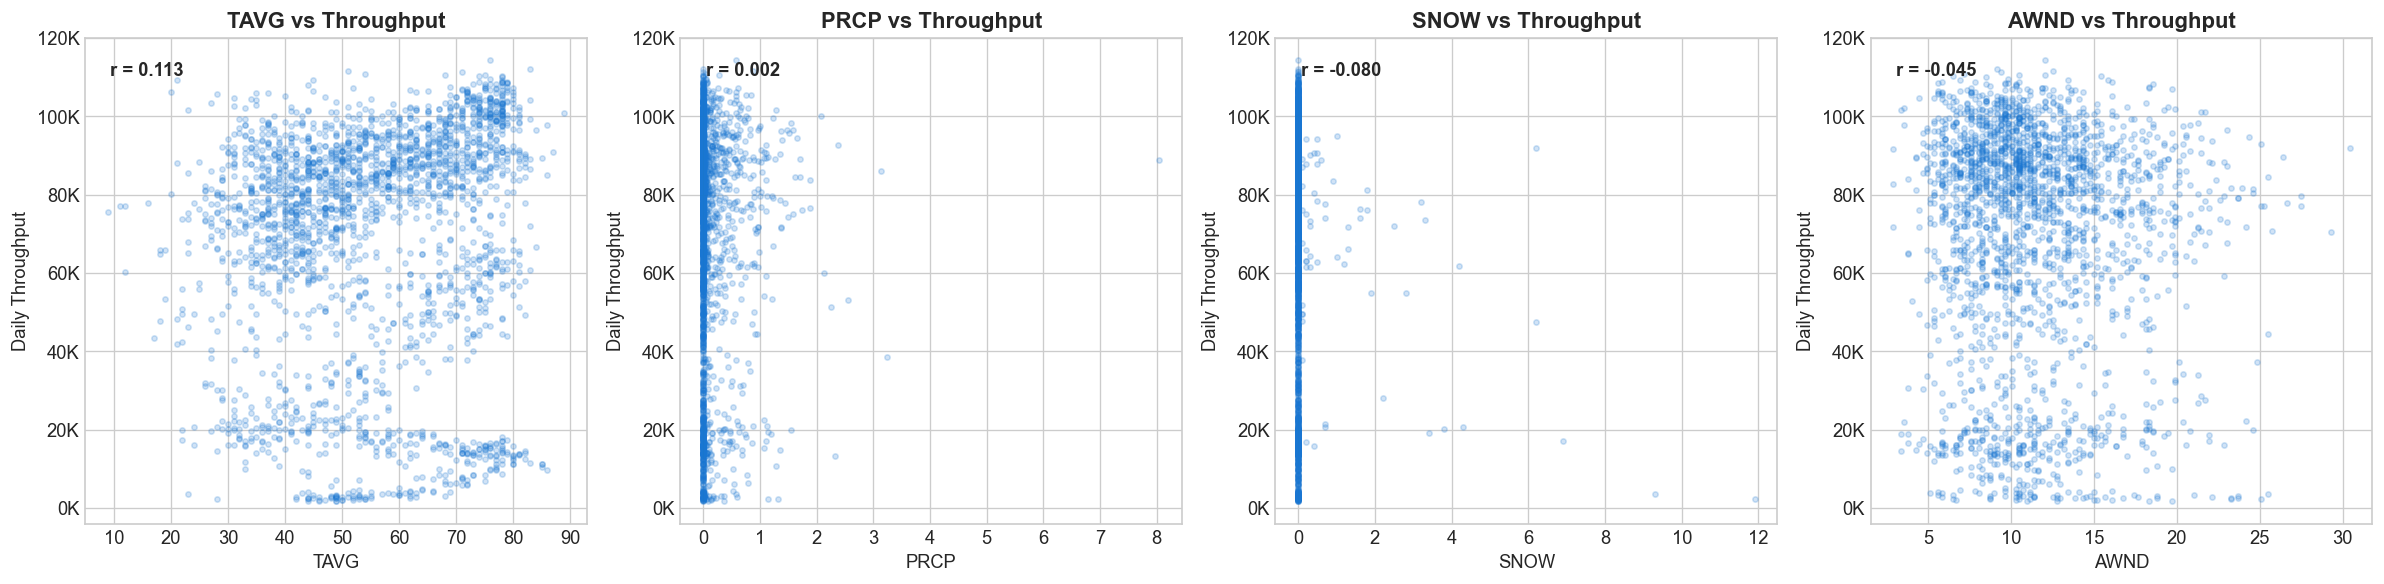

In [17]:
weather_features = ['TAVG', 'PRCP', 'SNOW', 'AWND']
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, feat in zip(axes, weather_features):
    valid = merged.dropna(subset=[feat])
    ax.scatter(valid[feat], valid['daily_throughput'], alpha=0.2, s=10, color='#1976D2')
    ax.set_xlabel(feat); ax.set_ylabel('Daily Throughput')
    ax.set_title(f'{feat} vs Throughput', fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    corr = valid[feat].corr(valid['daily_throughput'])
    ax.annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
               fontsize=11, fontweight='bold', va='top')
plt.tight_layout()
plt.savefig(f'{FIGURES}/05_weather_vs_throughput.png')
plt.show()

### 6.6 Scheduled Flights Over Time

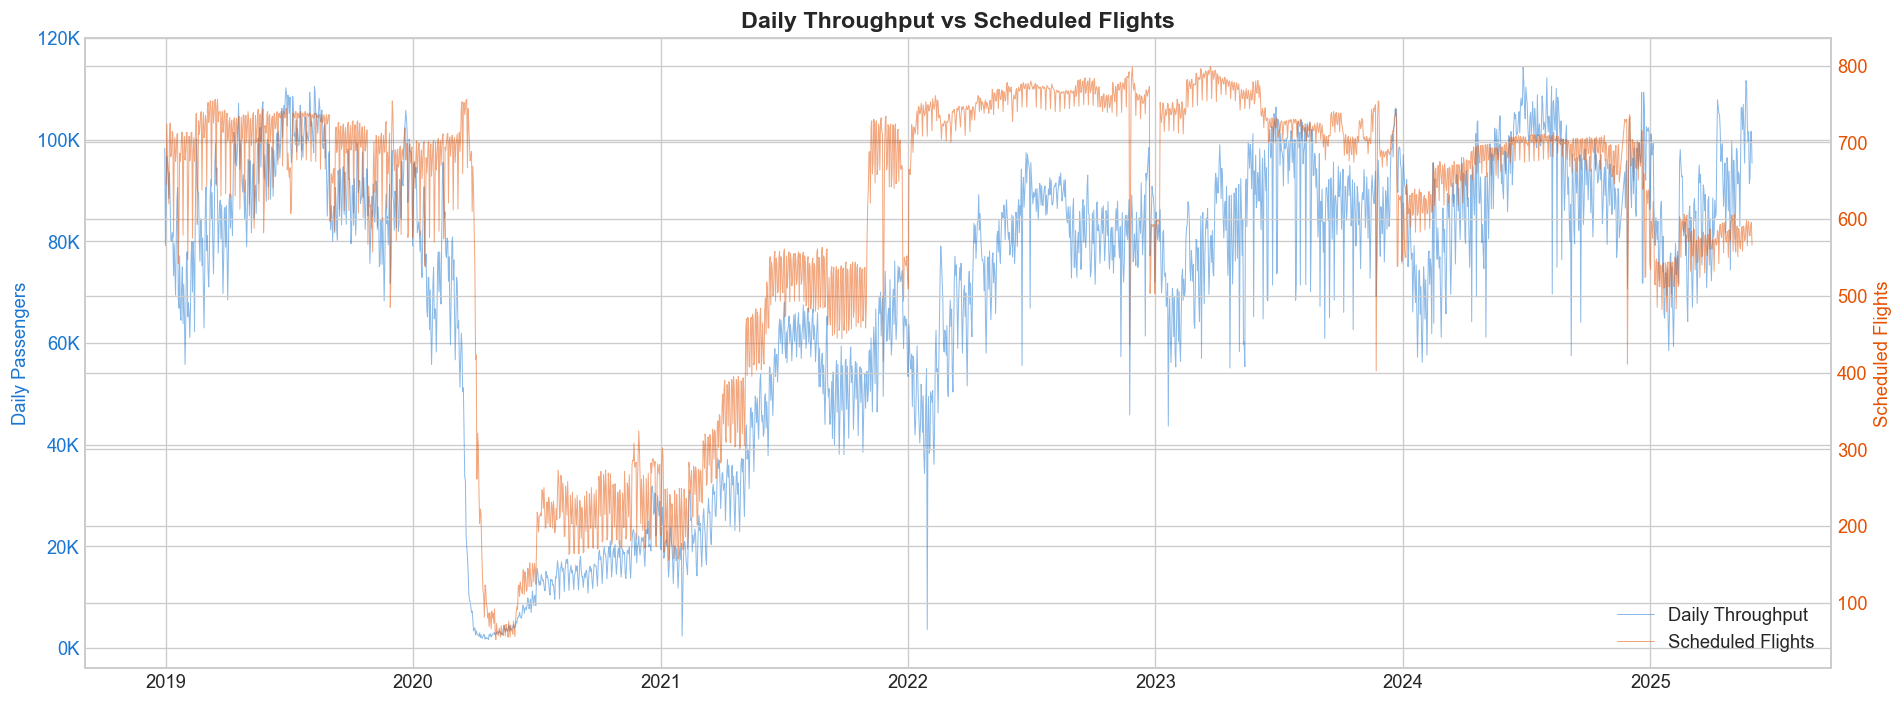

In [18]:
fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(merged['Date'], merged['daily_throughput'], lw=0.6, alpha=0.5,
         color='#1976D2', label='Daily Throughput')
ax1.set_ylabel('Daily Passengers', color='#1976D2')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
ax1.tick_params(axis='y', labelcolor='#1976D2')

ax2 = ax1.twinx()
ax2.plot(merged['Date'], merged['total_scheduled_flights'], lw=0.6, alpha=0.5,
         color='#E65100', label='Scheduled Flights')
ax2.set_ylabel('Scheduled Flights', color='#E65100')
ax2.tick_params(axis='y', labelcolor='#E65100')

ax1.set_title('Daily Throughput vs Scheduled Flights', fontsize=14, fontweight='bold')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
plt.tight_layout()
plt.savefig(f'{FIGURES}/08_throughput_vs_flights.png')
plt.show()

### 6.7 Scheduled Flights vs Throughput (Scatter)

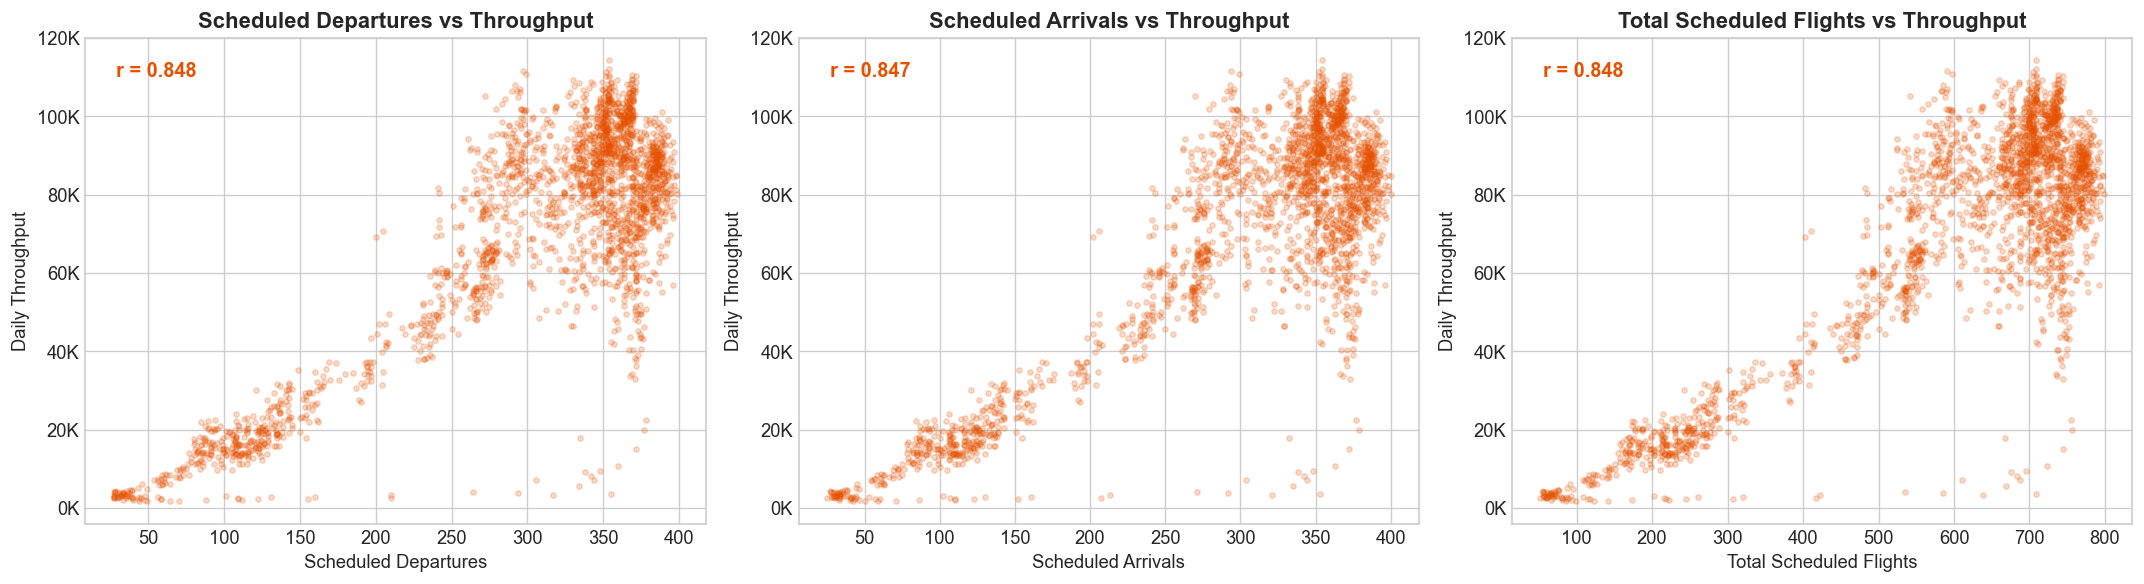

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
flight_scatter_cols = ['scheduled_departures', 'scheduled_arrivals', 'total_scheduled_flights']
for ax, col in zip(axes, flight_scatter_cols):
    valid = merged.dropna(subset=[col])
    ax.scatter(valid[col], valid['daily_throughput'], alpha=0.2, s=10, color='#E65100')
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel('Daily Throughput')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
    corr = valid[col].corr(valid['daily_throughput'])
    ax.annotate(f'r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
               fontsize=12, fontweight='bold', va='top', color='#E65100')
    ax.set_title(f'{col.replace("_", " ").title()} vs Throughput', fontweight='bold')
plt.tight_layout()
plt.savefig(f'{FIGURES}/09_flights_vs_throughput_scatter.png')
plt.show()

### 6.8 Passengers per Flight Over Time

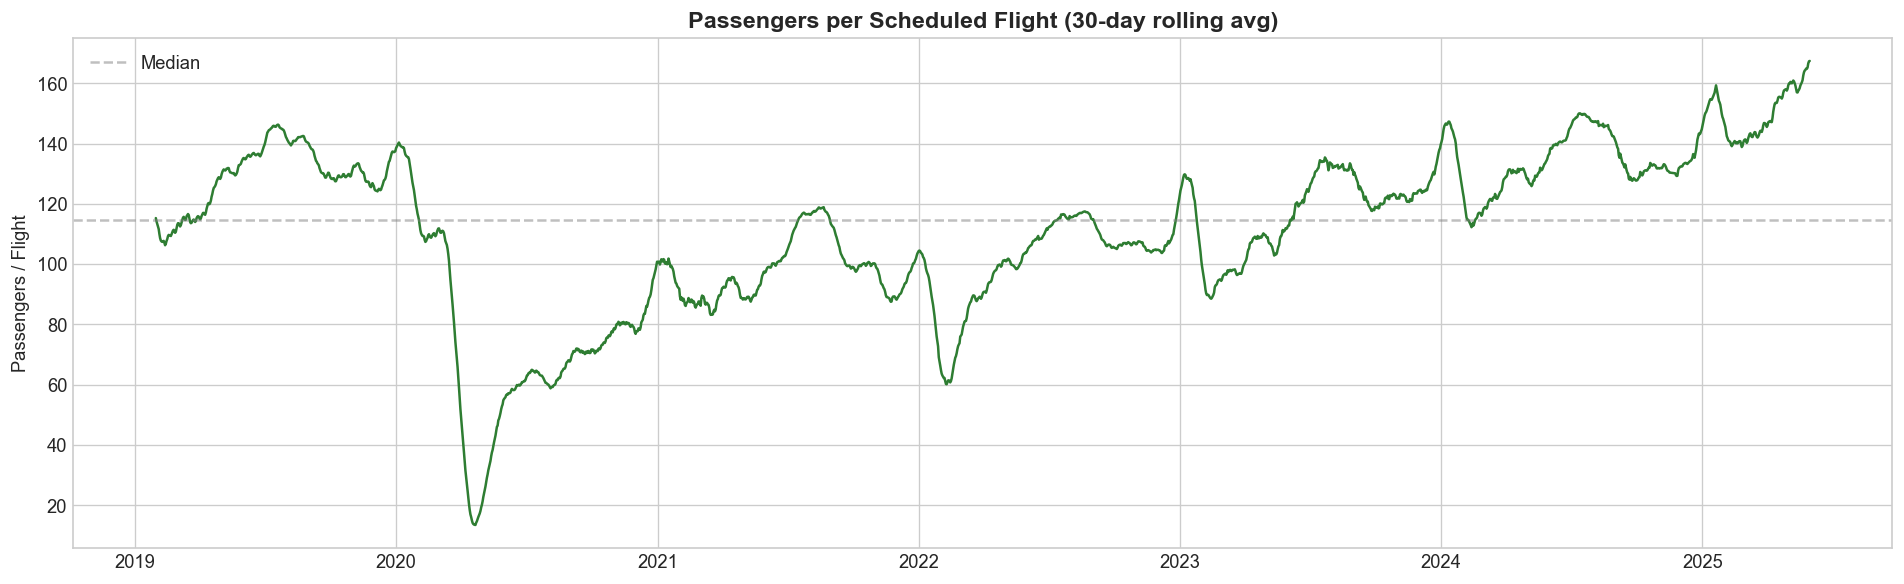

Passengers per flight:
  Mean:   111.8
  Median: 114.5
  COVID min: 5.1


In [20]:
merged['pax_per_flight'] = merged['daily_throughput'] / merged['total_scheduled_flights']

fig, ax = plt.subplots(figsize=(16, 5))
# 30-day rolling average for clarity
rolling = merged.set_index('Date')['pax_per_flight'].rolling(30).mean()
ax.plot(rolling.index, rolling.values, lw=1.5, color='#2E7D32')
ax.axhline(merged['pax_per_flight'].median(), color='gray', ls='--', alpha=0.5, label='Median')
ax.set_title('Passengers per Scheduled Flight (30-day rolling avg)', fontsize=14, fontweight='bold')
ax.set_ylabel('Passengers / Flight')
ax.legend()
plt.tight_layout()
plt.savefig(f'{FIGURES}/10_pax_per_flight.png')
plt.show()

print(f'Passengers per flight:')
print(f'  Mean:   {merged["pax_per_flight"].mean():.1f}')
print(f'  Median: {merged["pax_per_flight"].median():.1f}')
print(f'  COVID min: {merged["pax_per_flight"].min():.1f}')

### 6.9 Correlation Heatmap (all features)

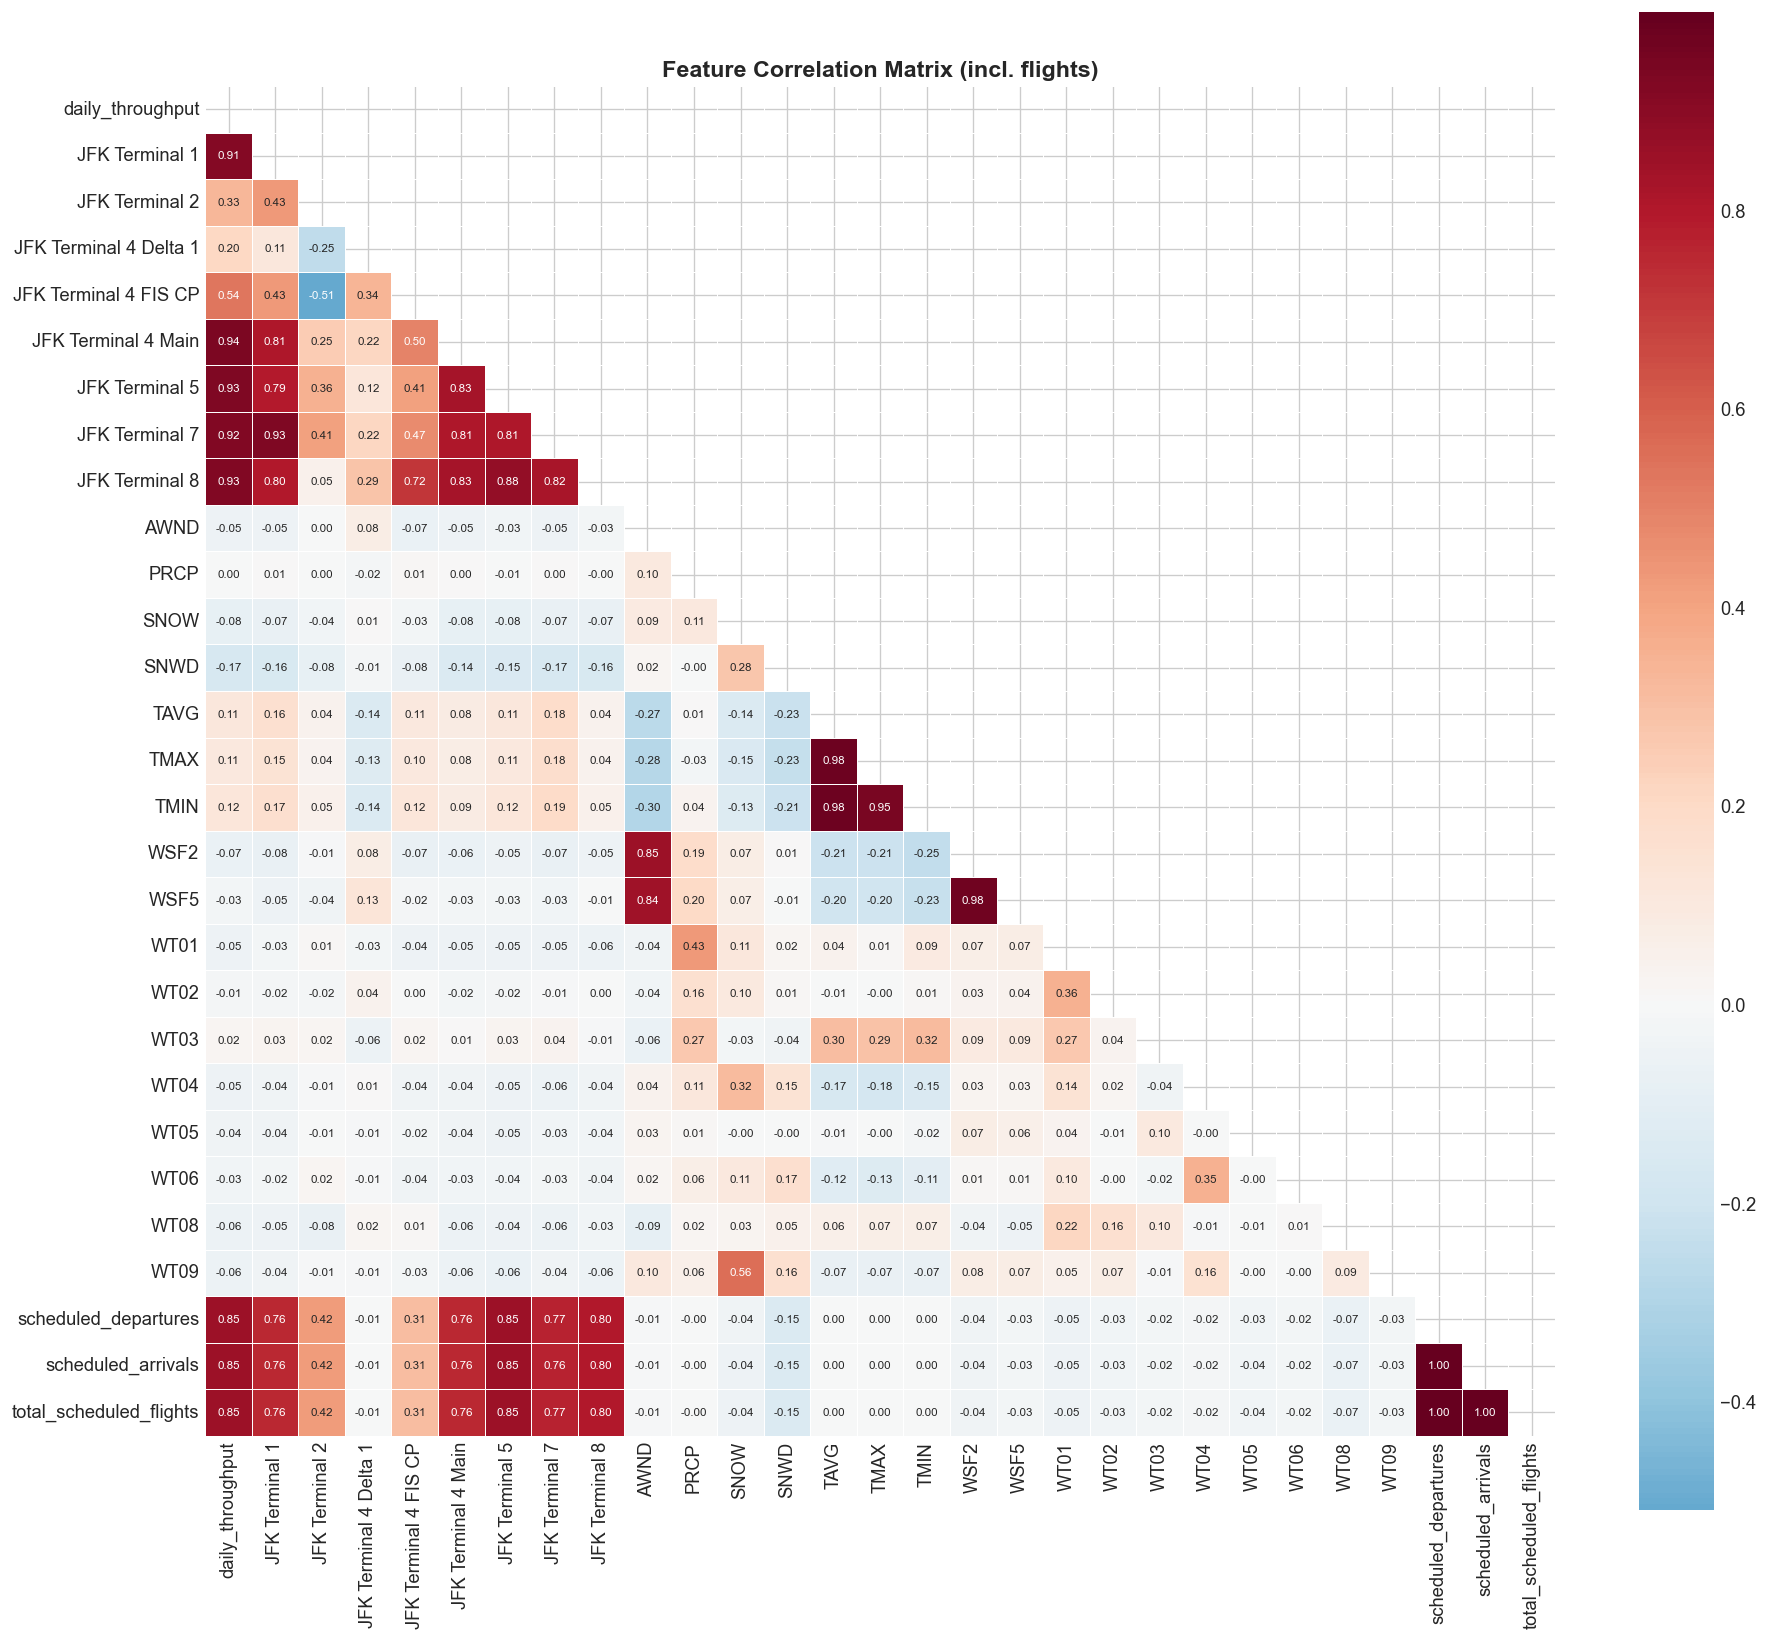

In [21]:
numeric_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
# Remove helper columns
for c in ['pax_per_flight']:
    if c in numeric_cols:
        numeric_cols.remove(c)

fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones((len(numeric_cols), len(numeric_cols)), dtype=bool))
sns.heatmap(merged[numeric_cols].corr(), mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 7})
ax.set_title('Feature Correlation Matrix (incl. flights)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{FIGURES}/06_correlation_heatmap.png')
plt.show()

### 6.10 COVID Impact by Year

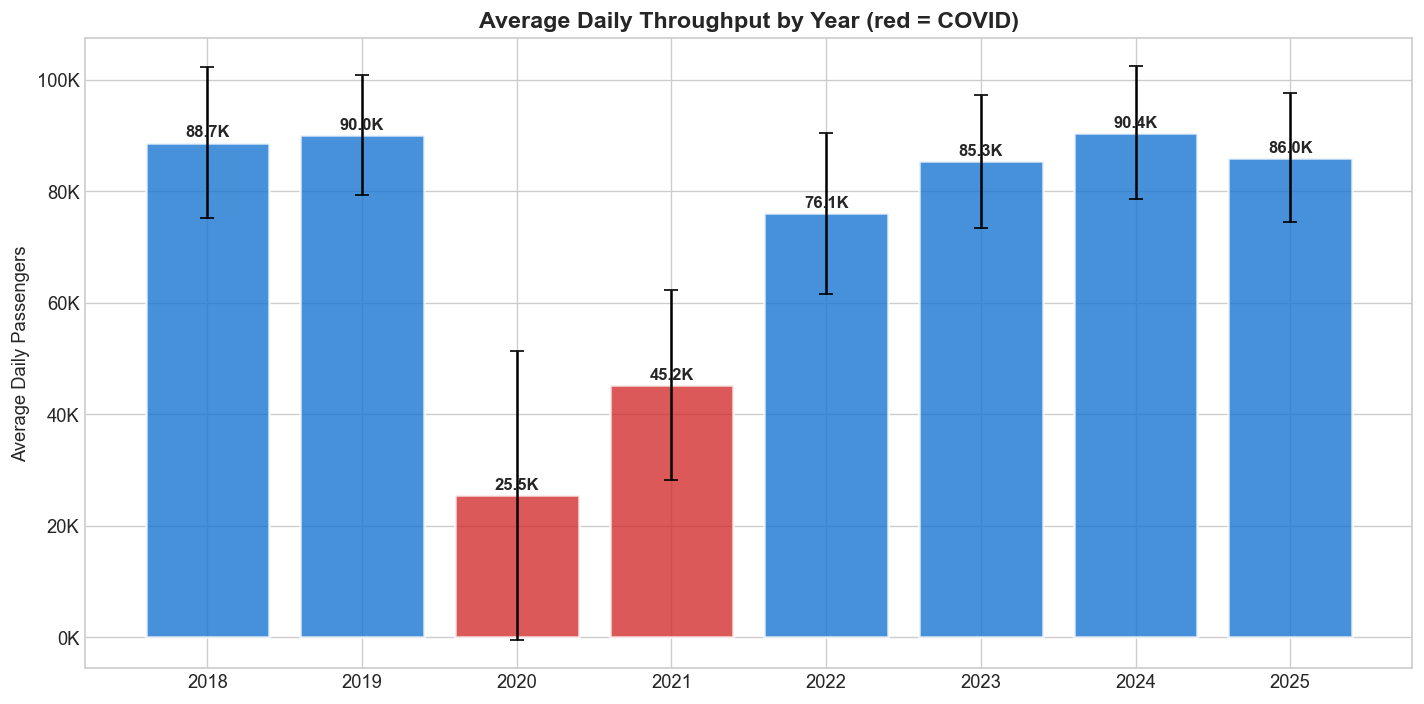

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
yearly = merged.groupby(merged['Date'].dt.year)['daily_throughput'].agg(['mean','std']).reset_index()
yearly.columns = ['year','mean','std']
colors = ['#D32F2F' if y in [2020,2021] else '#1976D2' for y in yearly['year']]
bars = ax.bar(yearly['year'], yearly['mean'], yerr=yearly['std'],
              color=colors, alpha=0.8, capsize=4, edgecolor='white', lw=1.5)
ax.set_title('Average Daily Throughput by Year (red = COVID)', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Daily Passengers')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
for bar, val in zip(bars, yearly['mean']):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1000,
            f'{val/1000:.1f}K', ha='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{FIGURES}/07_yearly_average.png')
plt.show()

## 7. Key EDA Findings

| Finding | Detail |
|---------|--------|
| **Dataset size** | ~2,337 days (Dec 2018 — May 2025) |
| **Target range** | 1,640 (COVID trough) to 114,397 passengers/day |
| **COVID shock** | 2020 avg dropped to ~25K/day (vs ~80K pre-COVID), full recovery by 2023 |
| **Day-of-week** | Friday/Sunday highest (travel days); Tuesday/Wednesday lowest |
| **Seasonality** | July/August peak; January/February trough |
| **Terminal closures** | T2 closed ~2023, T7 closed ~2024 |
| **Weather correlation** | TAVG has moderate positive correlation with throughput (~0.3); SNOW/PRCP weakly negative |
| **Flight correlation** | Scheduled flights very strongly correlated with throughput, likely the strongest predictor |
| **Pax per flight** | Collapsed during COVID (load factor crash), recovered to ~120–130 by 2023+ |
| **Missing data** | 8 missing dates in TSA; 2 days missing flight data; ~1% missing wind speed |

---
